In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [3]:
five_star_ratings_index = df.index[df['Rating']==5].tolist()

In [4]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df = df.drop(index=five_star_ratings_index)
#Great! We are doing good so far.
df = df.reset_index()
df = df.drop(columns=['index'])
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"excellent staff, housekeeping quality hotel ch...",4
4,"poor value stayed monaco seattle july, nice ho...",2
...,...,...
11432,not impressed unfriendly staff checked asked h...,2
11433,great location price view hotel great quick pl...,4
11434,"ok just looks nice modern outside, desk staff ...",2
11435,hotel theft ruined vacation hotel opened sept ...,1


In [5]:
#Also let us add a sentiment column to our modified dataframe

df_sentiment = pd.DataFrame(data = np.zeros(11437), columns=['Sentiment'],dtype='int64')
df_model = pd.concat([df,df_sentiment], axis = 1)

#We need to update the sentiment. If rating is 4 sentiment will be positive = 1

for i in range(11437):
  if df_model.at[i,'Rating']==4:
    df_model.at[i,'Sentiment']=1

df_model

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"excellent staff, housekeeping quality hotel ch...",4,1
4,"poor value stayed monaco seattle july, nice ho...",2,0
...,...,...,...
11432,not impressed unfriendly staff checked asked h...,2,0
11433,great location price view hotel great quick pl...,4,1
11434,"ok just looks nice modern outside, desk staff ...",2,0
11435,hotel theft ruined vacation hotel opened sept ...,1,0


In [6]:
df_sample = df_model.sample(n=1000, axis=0,random_state=69)
df_sample = df_sample.reset_index(drop=True)
df_sample

,Review,Rating,Sentiment
0,"good place stay, stayed week july 4th holiday,...",4,1
1,good location overpriced hotel boston hotels o...,3,0
2,not fully satisfied husband stayed goodwood pa...,3,0
3,second time hotel didnt disapoint staying hote...,4,1
4,"inclusive runs guaranteed, party 6 77 yr. old ...",1,0
...,...,...,...
995,"great location location best thing hotel, just...",4,1
996,beware food water service riu tiano experience...,1,0
997,great place quaint hotel middle las ramblas pl...,4,1
998,ummmm just returned long weekend not sure star...,2,0


In [7]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\koush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\koush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def clean_review(review, stemmer = SnowballStemmer('english'), stop_words = set(stopwords.words('english'))):

  words = word_tokenize(review.lower())
  
  filtered_words = []
  for word in words:
      if word not in stop_words and word.isalpha(): #(isalphabet)
          stemmed_word = stemmer.stem(word)
          filtered_words.append(stemmed_word)
  return filtered_words

stemmed_nested_list = df_sample.Review.apply(clean_review) #applied this to the sample!
print(stemmed_nested_list)

0      [good, place, stay, stay, week, juli, holiday,...
1      [good, locat, overpr, hotel, boston, hotel, ov...
2      [fulli, satisfi, husband, stay, goodwood, park...
3      [second, time, hotel, didnt, disapoint, stay, ...
4      [inclus, run, guarante, parti, old, adult, adu...
                             ...                        
995    [great, locat, locat, best, thing, hotel, las,...
996    [bewar, food, water, servic, riu, tiano, exper...
997    [great, place, quaint, hotel, middl, las, ramb...
998    [ummmm, return, long, weekend, sure, start, po...
999    [great, end, vacat, stay, locat, carniv, cruis...
Name: Review, Length: 1000, dtype: object


In [9]:
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]
unique_words = pd.Series(flat_stemmed_list).value_counts() #It is ordering words from more frequent appearances to less frequent
NUMBER_OF_UNIQUE_WORDs = len(unique_words)
print('Number of unique words:',len(unique_words))

Number of unique words: 7933


In [10]:
#Now I want to associate in a dictionary a word to the number of appearances it has. We do this for the most 700 frequent words
NUMBER_OF_WORDS=700
word_appearances_dict={}
for i in range(NUMBER_OF_WORDS):
  word_appearances_dict[unique_words.index[i]]=unique_words[i]

#Create an ID for every unique word. We create our vocabulary.

word_id_dict = {}

for i in range(len(unique_words)):
  word_id_dict[unique_words.index[i]]=i

#Id to word dictionary
id_word_dict = {v: k for k, v in word_id_dict.items()}

#We convert the words in stemmed nested list to its word ID

stemmed_nested_list = stemmed_nested_list.tolist()
stemmed_nested_list_IDs = []

for sublista in stemmed_nested_list:
  sublista_ID=[]
  for elemento in sublista:
    sublista_ID.append(word_id_dict[elemento])
  stemmed_nested_list_IDs.append(sublista_ID)

In [11]:
#We create the words database

NUMBER_OF_ROWS = 1000 #number of reviews

NUMBER_OF_COLS = NUMBER_OF_WORDS #number of unique words considered
df_words = pd.DataFrame(np.zeros((NUMBER_OF_ROWS, NUMBER_OF_COLS)),dtype ='int64')

df_words

row = 0
for lista in stemmed_nested_list_IDs:
  for elemento in lista:
    if elemento<NUMBER_OF_WORDS:
      df_words.at[row,elemento] =1
  row+=1

df_words

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
0,1,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,0,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,1,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,1,1,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
996,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
997,1,0,0,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
998,1,1,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [12]:
df_model_sentiment = pd.concat([df_sample.loc[:,['Sentiment']],df_words], axis = 1)
df_model_sentiment

,Sentiment,0,1,2,3,4,5,6,7,8,...,690,691,692,693,694,695,696,697,698,699
0,1,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,0,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
996,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
997,1,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
998,0,1,1,0,1,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [13]:

def set_reviews(word_id):
    globals()[f"set_reviews_{word_id}"] = set()
    for i in range(1000):
        if df_model_sentiment.iat[i,word_id+1]==1:
            globals()[f"set_reviews_{word_id}"].add(i)
                 
for i in range(700):
       set_reviews(i)

In [14]:
set_reviews_699

{0, 47, 68, 116, 133, 379, 380, 395, 512, 677, 717, 780, 789, 885}

In [15]:
import random
SAMPLE_SIZE=50


random.seed(10)
randomlist = []
for i in range(0,SAMPLE_SIZE):
  n = random.randint(0,999)
  randomlist.append(n)




set_ID_pos = set()
set_ID_neg = set()


max_set=set()
max_set.add(0)
max_set.add(1)


for i in range(0,700):
  WORD_ID=i #Up to 699
  punctuations_word=set()
  for i in randomlist: #We take a random sample representing the 10% of the total of the rows
    if df_model_sentiment.iat[i,WORD_ID+1]==1: #word corresponding to 0 is hotel for example
      punctuations_word.add(df_model_sentiment.Sentiment[i])
      if 0 in punctuations_word:
        set_ID_pos.add(WORD_ID)
      if 1 in punctuations_word:
        set_ID_neg.add(WORD_ID)
    if punctuations_word==max_set:
      break;

In [16]:
print('Lenght of set 1 is', len(set_ID_pos), 'out of 700')
print('Lenght of set 2 is', len(set_ID_neg), 'out of 700')

Lenght of set 1 is 568 out of 700
Lenght of set 2 is 443 out of 700


In [77]:
# unique_words_reduced = unique_words[0:700]
# nodos=dict(unique_words_reduced)

import networkx as nx

G = nx.Graph()
# for count, nodo in enumerate(nodos):
#     G.add_node(nodo)

In [78]:
THRESHOLD_1=10 #index_distance
THRESHOLD_2=5 #min_shared_reviews
THRESHOLD_3=15 #max_shared_reviews

edgesColor={}

#for i in G.edges:
    #edgesColor[i]='red'


for index in set_ID_pos:
    word=id_word_dict[index]
    for i in set_ID_neg:
        word1=id_word_dict[i]
        if str(word)!=str(word1) and abs(index-i)<THRESHOLD_1 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])>THRESHOLD_2 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])<THRESHOLD_3:
            #G.add_edge([(str(word), str(word1))],color='red')
            G.add_nodes_from([str(word1)],color=[0,1,1])
            G.add_nodes_from([str(word)],color=[1,0,1])
            G.add_edges_from([(str(word), str(word1))],color=[0,0,1])#red
            #edgesColor[i]='red'
            #G.add_edge(1,2,color='r',weight=2)
            
# for index in set_ID_neg:
#     word=id_word_dict[index]
#     for i in set_ID_neg:
#         word1=id_word_dict[i]
#         if str(word)!=str(word1) and abs(index-i)<THRESHOLD_1 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])>THRESHOLD_2 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])<THRESHOLD_3:
#             #G.add_edge([(str(word), str(word1))],color='black')
           
#             G.add_edges_from([(str(word), str(word1))],color=[0,0,1])#blue
#             #edgesColor[i]='black'
            
# for index in set_ID_pos:
#     word=id_word_dict[index]
#     for i in set_ID_pos:
#         word1=id_word_dict[i]
#         if str(word)!=str(word1) and abs(index-i)<THRESHOLD_1 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])>THRESHOLD_2 and len(globals()[f"set_reviews_{index}"]&globals()[f"set_reviews_{i}"])<THRESHOLD_3:
#             #G.add_edge([(str(word), str(word1))],color='green')
#             G.add_edges_from([(str(word), str(word1))],color=[1,0,0])#blue

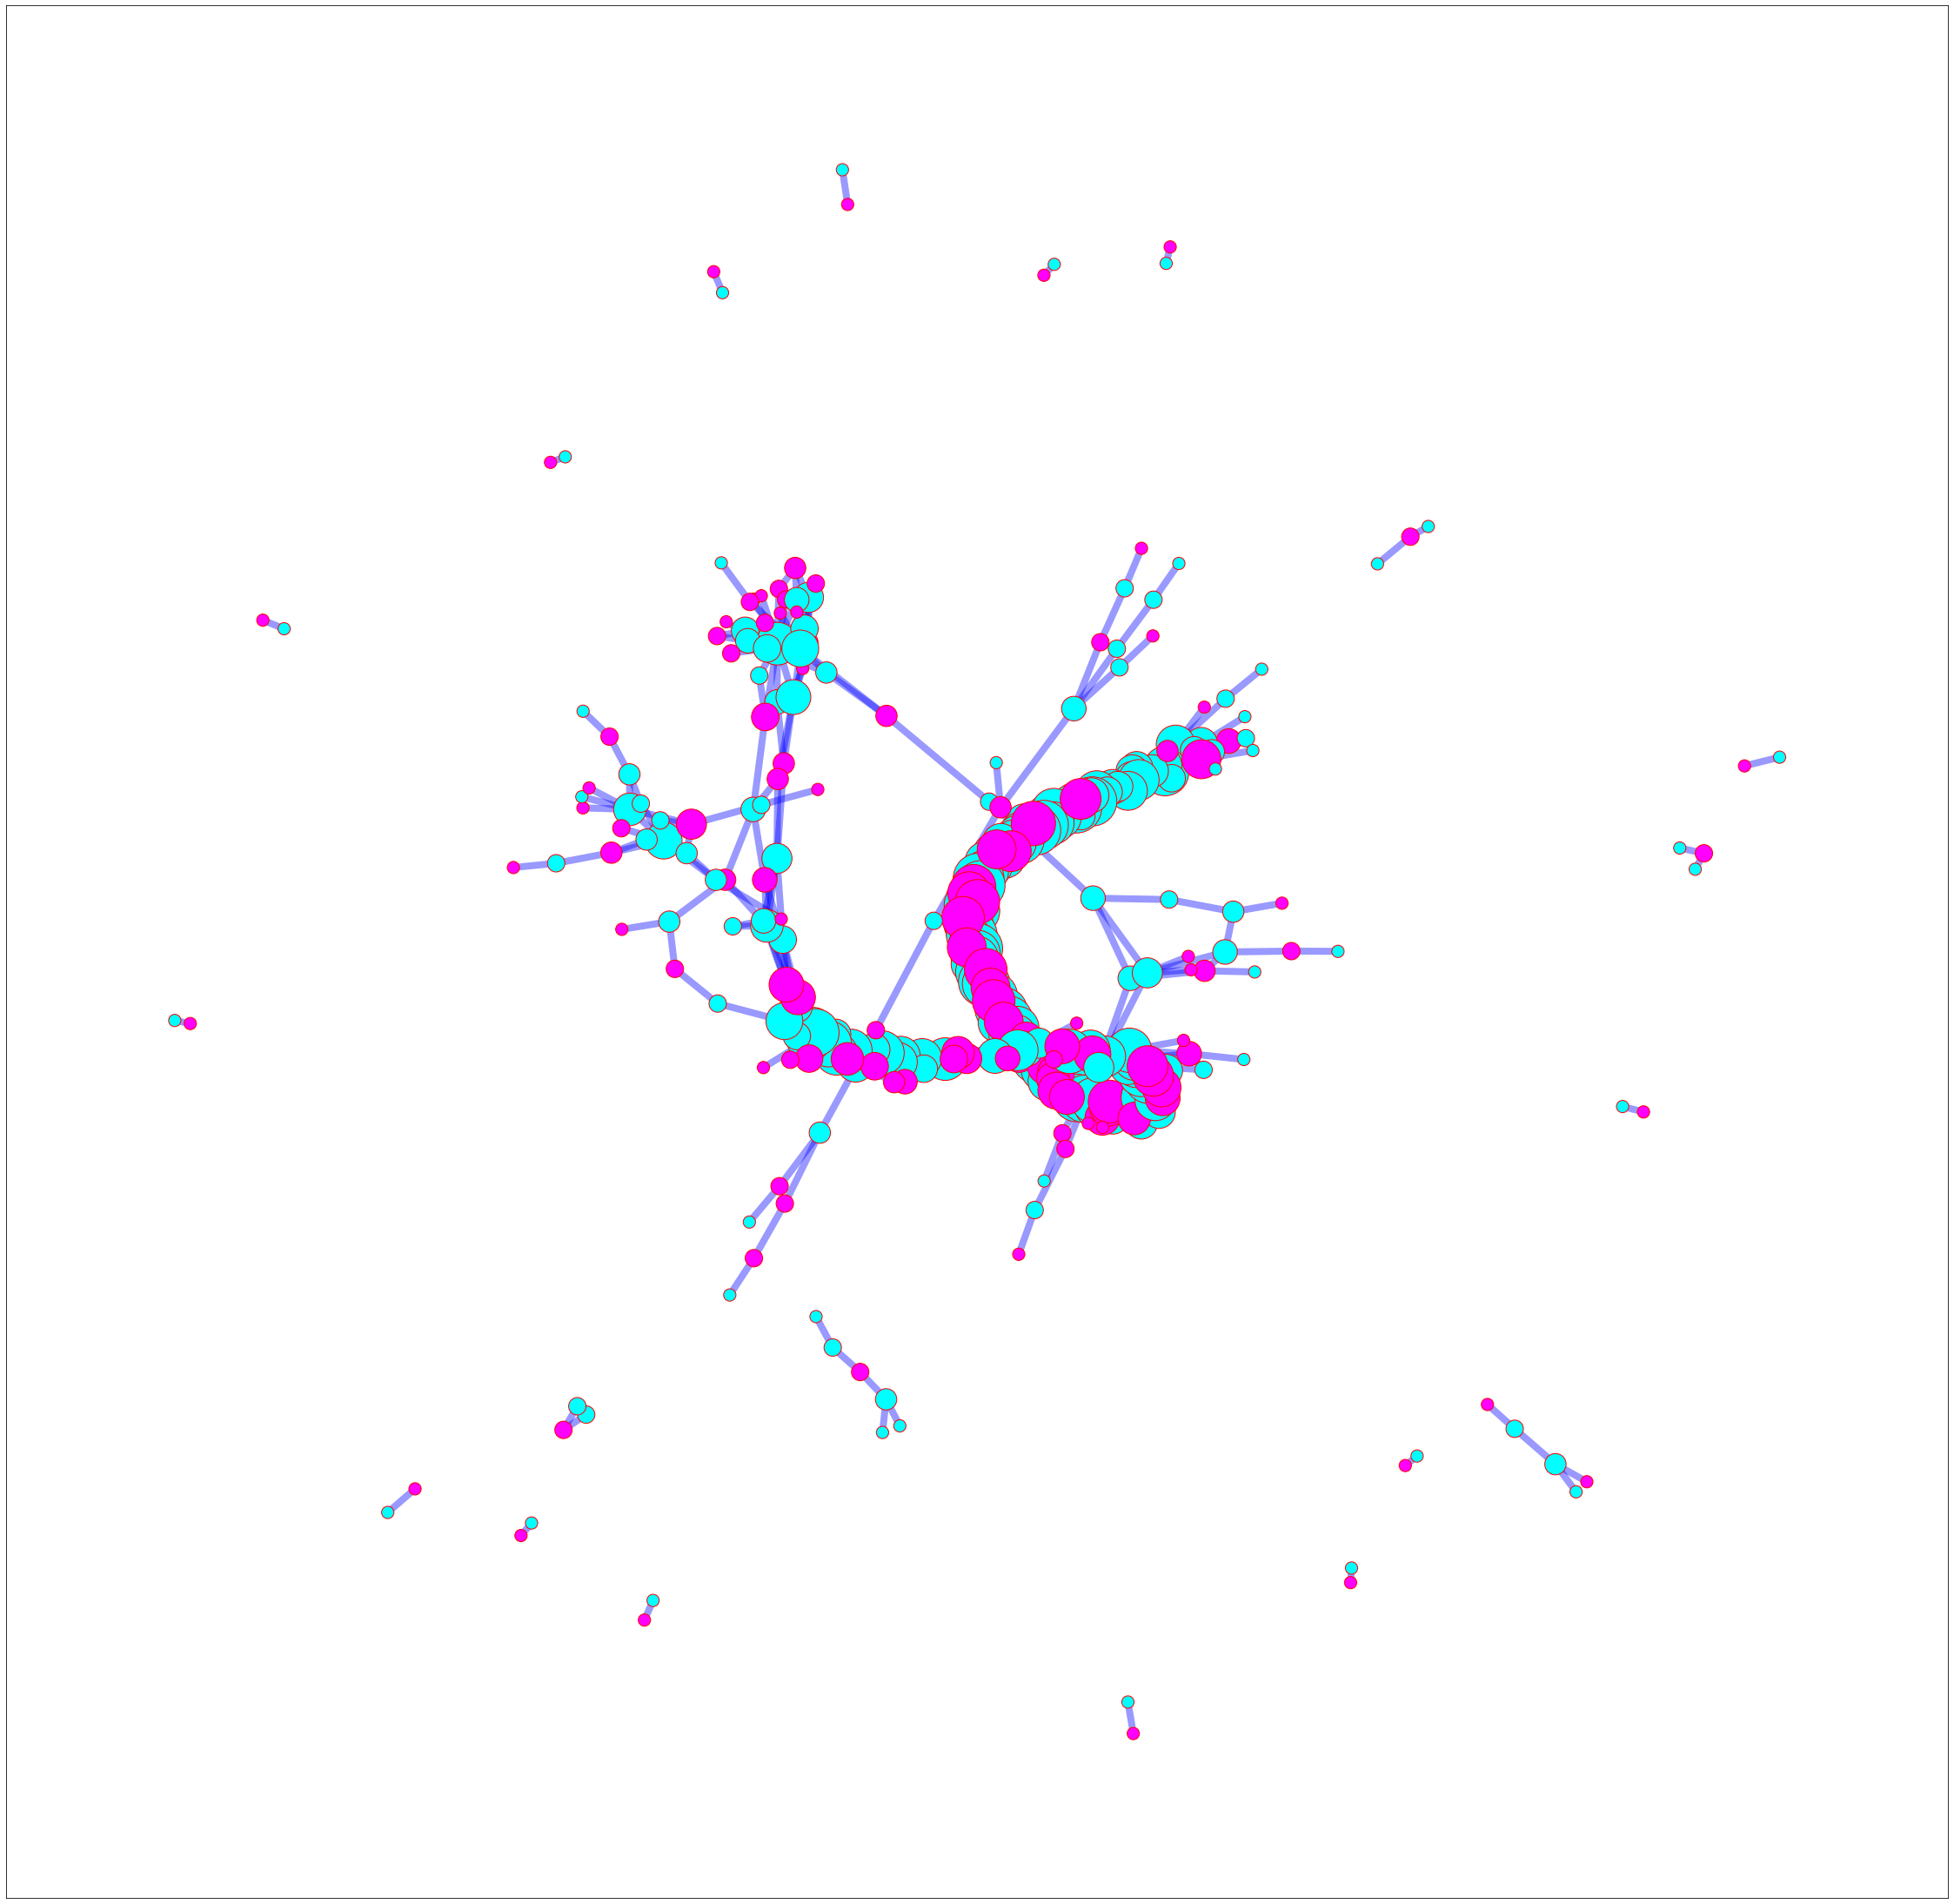

In [79]:
plt.figure(figsize=(40,40))
pos =nx.spring_layout(G,seed=10)
d = dict(G.degree)

nx.draw_networkx_nodes(G, pos,nodelist=d.keys(), node_color=list(nx.get_node_attributes(G, 'color').values()), edgecolors='red', node_size=[v * 200 for v in d.values()]) #[v * 100 for v in d.values()]
nx.draw_networkx_edges(G, pos, alpha=0.4, width=8.0, edge_color=list(nx.get_edge_attributes(G, 'color').values()))

In [82]:
nx.set_edge_attributes(G, edgesColor, 'color')

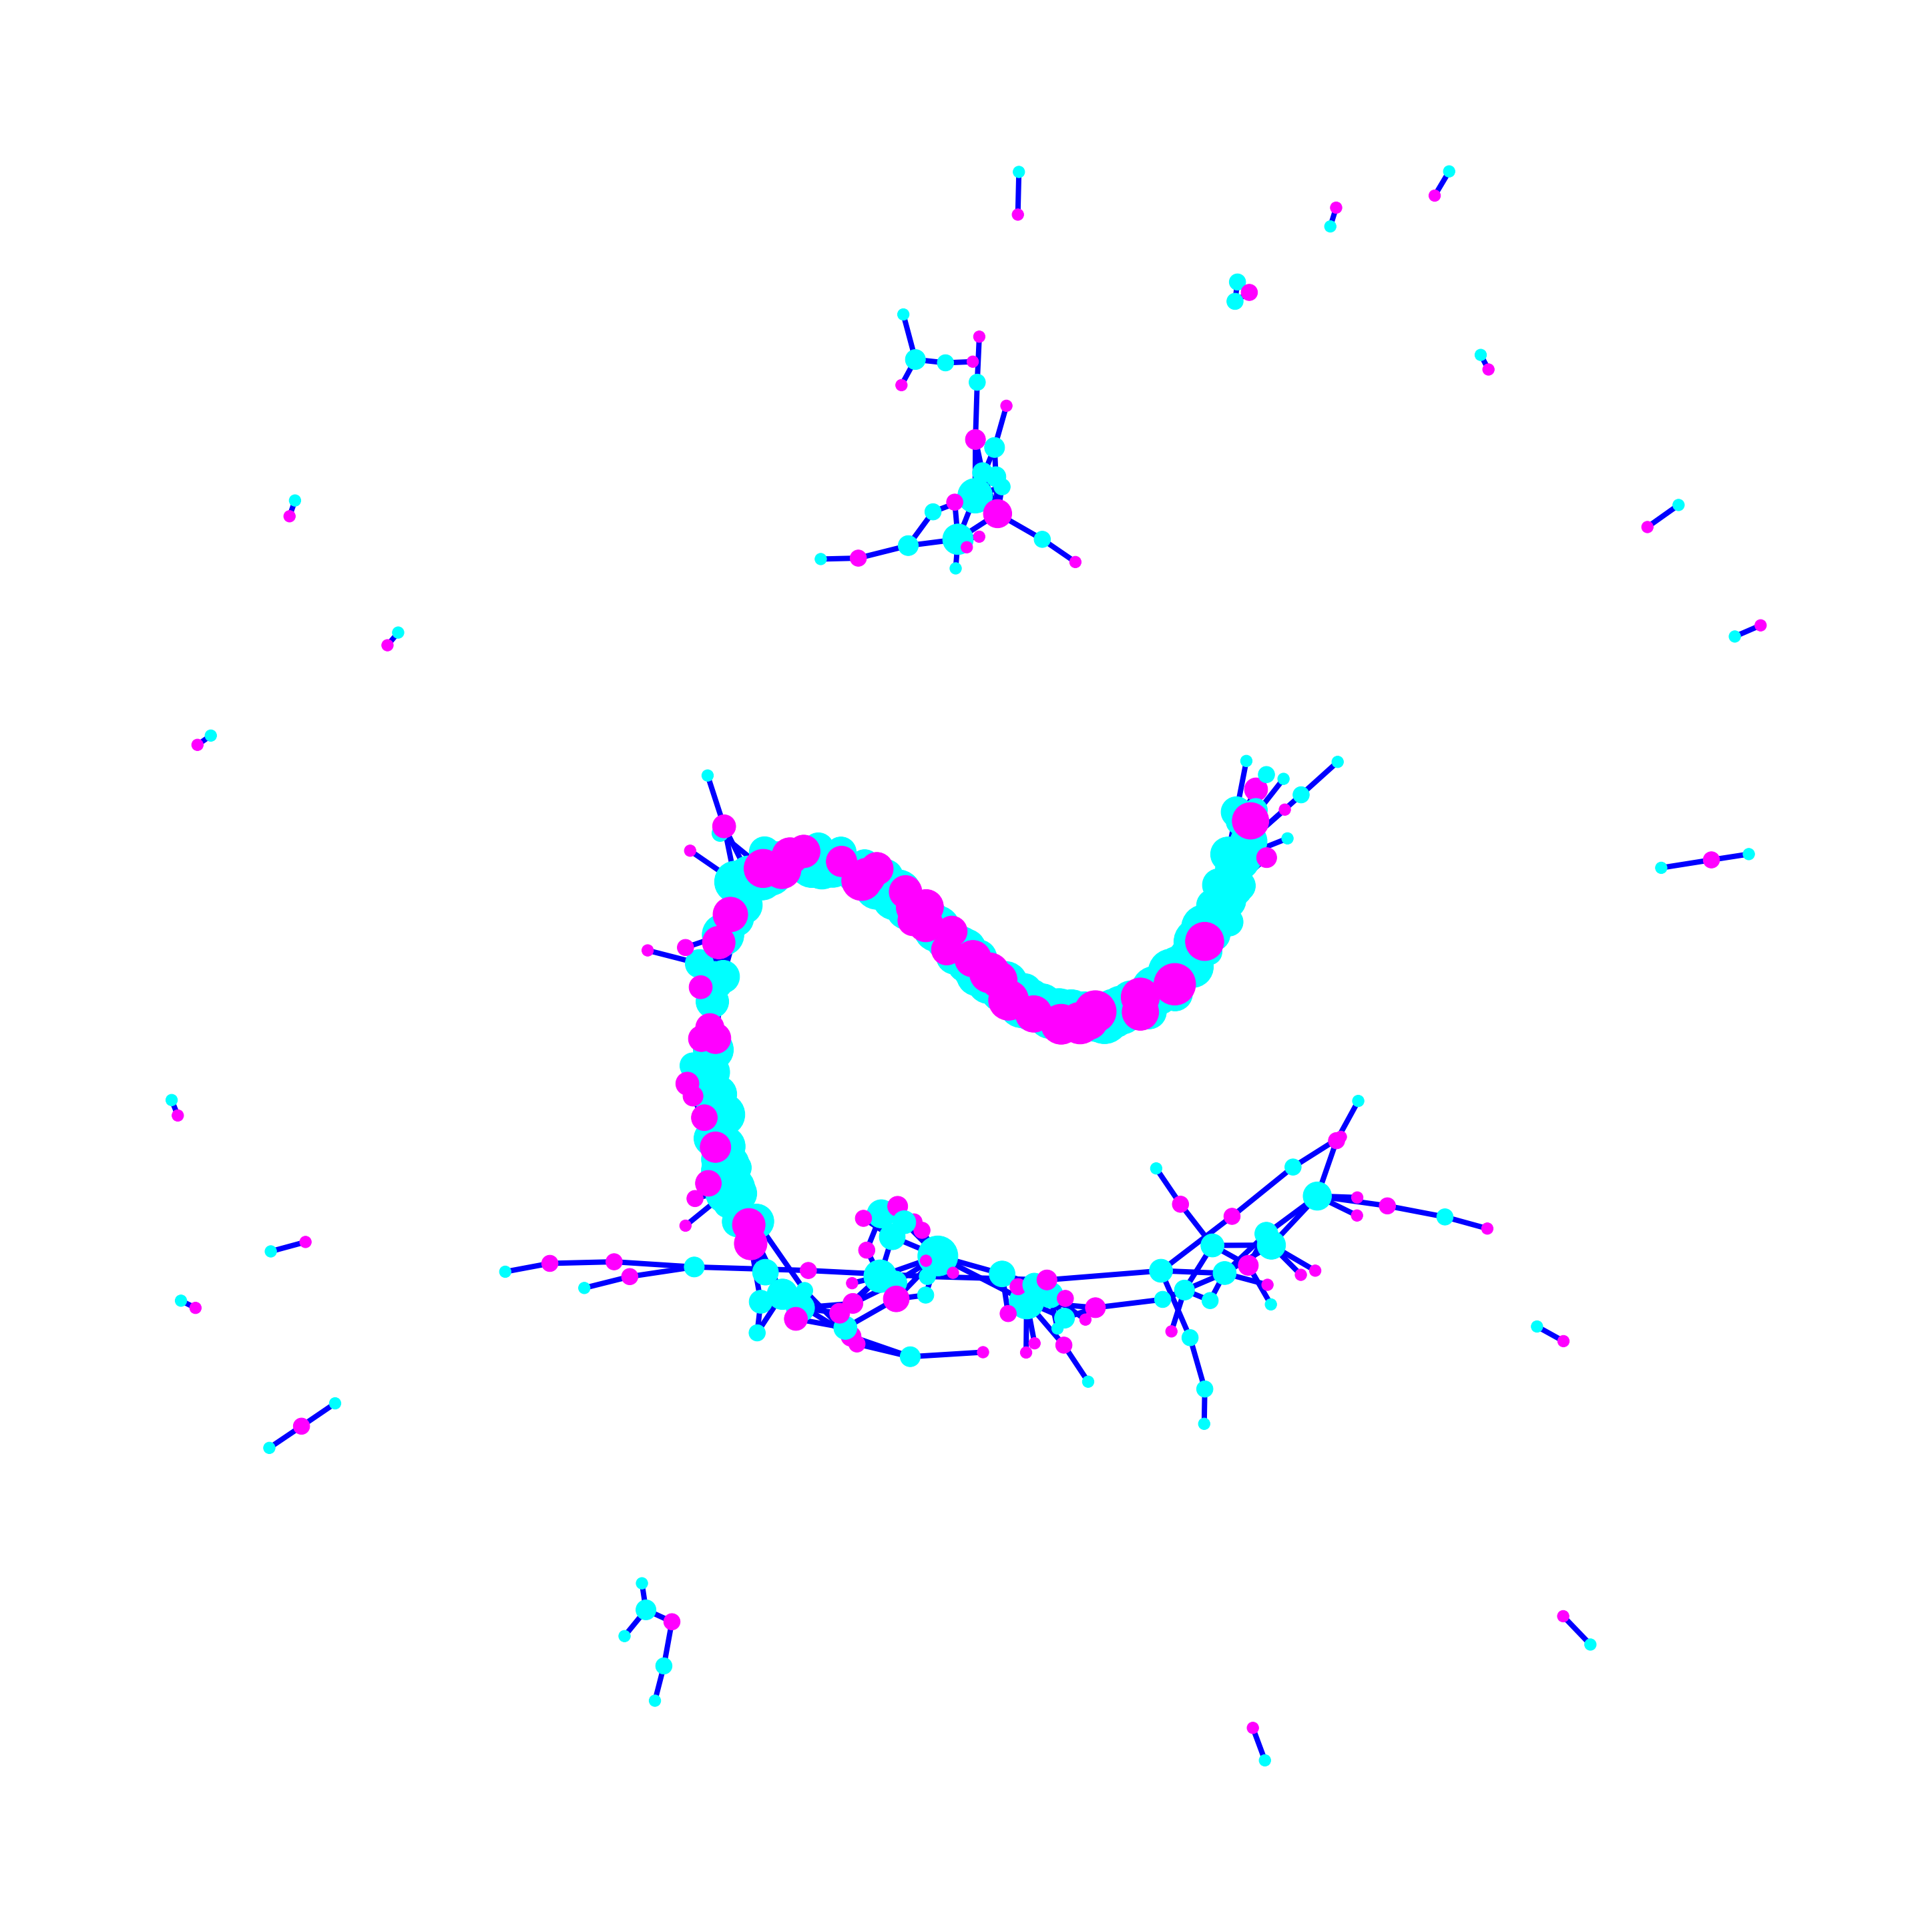

In [83]:
plt.figure(figsize=(40,40))
pos =nx.spring_layout(G)

nx.draw(
    G, 
    pos,
    with_labels=False,
    width=8.0,
    edge_color=list(nx.get_edge_attributes(G, 'color').values()),
    node_size=[v * 300 for v in d.values()],
    node_color=list(nx.get_node_attributes(G, 'color').values()),
)
plt.show()

In [68]:
# largest connected component
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

In [69]:
# compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

In [70]:
# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

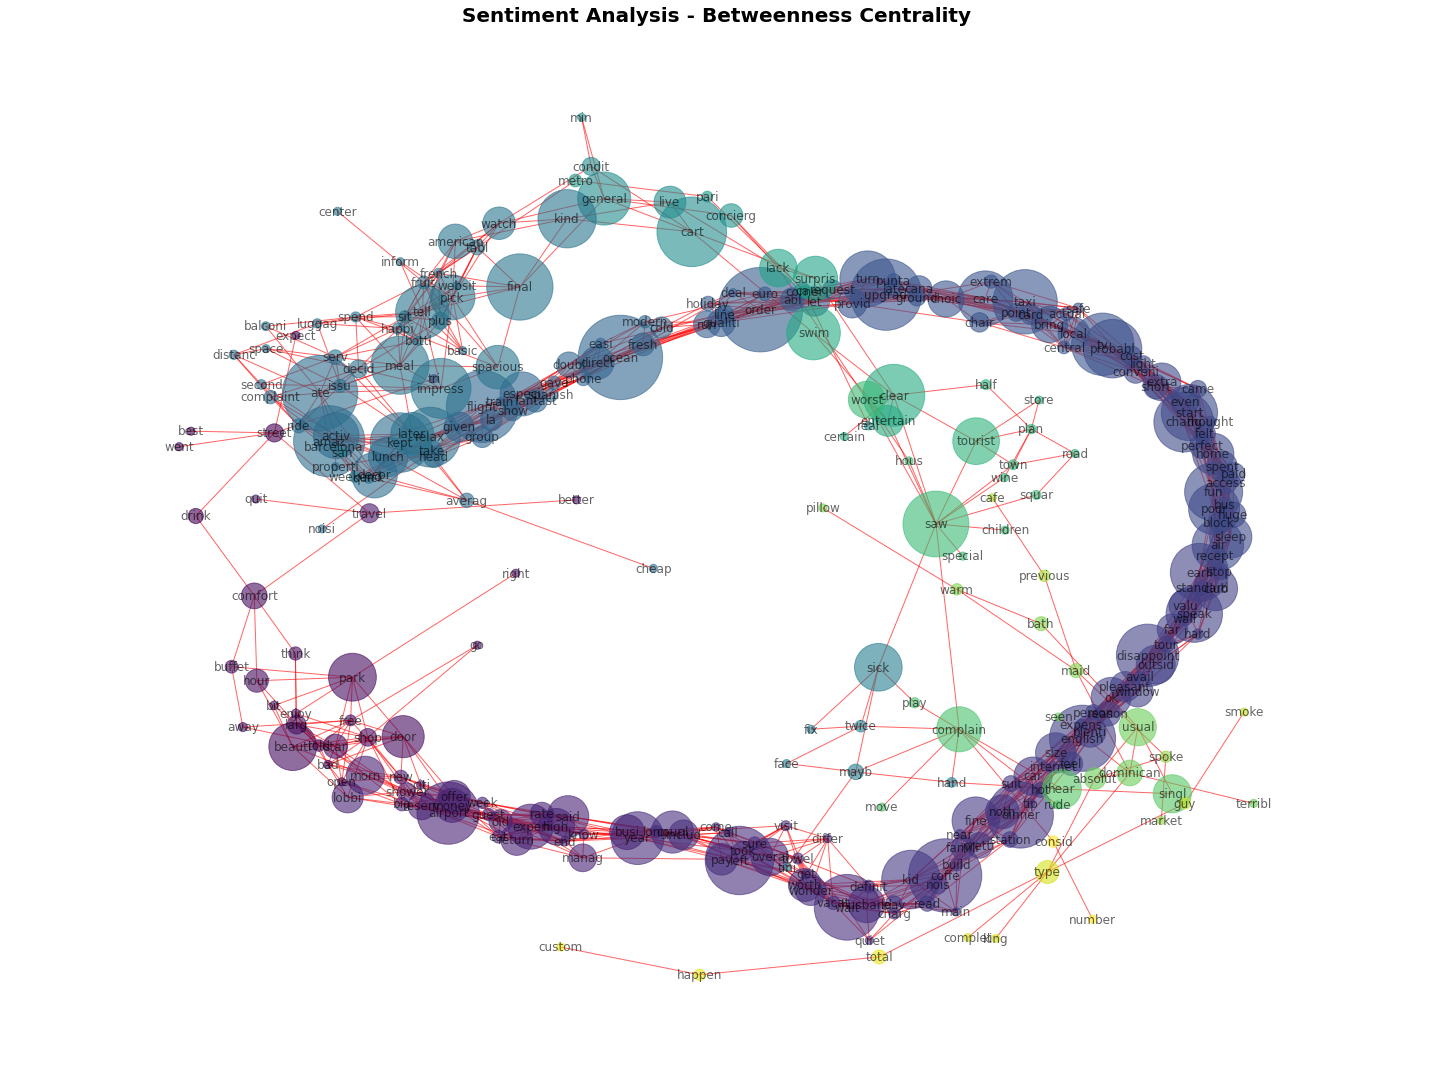

In [72]:
#### draw graph ####

fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=42)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]

nx.draw_networkx(
    H,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    edge_color="r",
    alpha=0.6,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Sentiment Analysis - Betweenness Centrality", font)
# Change font color for legend
font["color"] = "b"


# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()